This is our recreation of Lehtinen et al.'s paper "Noise2Noise". 

## Imports

In [1]:
import numpy as np
import tensorflow as tf
import keras
from importlib import reload

In [2]:
from helpers import generators, utils, noise_models
from models import unet_n2n, irfan_2020

In [3]:
reload(utils)
reload(noise_models)

<module 'helpers.noise_models' from '/Users/antrikshdhand/Documents/github/thesis-ml/ml/main/helpers/noise_models.py'>

In [4]:
np.random.seed(42)

## Initialise data

In [5]:
TRAIN_IMAGE_DIR = "../../raw_datasets/imagenet-10k"
VAL_IMAGE_DIR = "../../raw_datasets/BSDS300/images/train"
TEST_IMAGE_DIR = "../../raw_datasets/BSDS300/images/test"

NUM_EPOCHS = 50
GPU_BATCH_SIZE = 4
DATA_BATCH_SIZE = 16

In [6]:
noise_model = noise_models.gaussian_noise

In [7]:
training_gen = generators.NoisyImageTrainGenerator(
    image_dir=TRAIN_IMAGE_DIR,
    input_noise_model=noise_model,
    target_noise_model=noise_model,
    batch_size=DATA_BATCH_SIZE,
    patch_edge_size=192,
    zero_one_normalisation=True,
    greyscale=True
)

validation_gen = generators.NoisyImageValGenerator(
    image_dir=VAL_IMAGE_DIR,
    noise_model=noise_model,
    batch_size=DATA_BATCH_SIZE,
    patch_edge_size=192,
    zero_one_normalisation=True,
    greyscale=True
)

test_gen = generators.NoisyImageValGenerator(
    image_dir=TEST_IMAGE_DIR,
    noise_model=noise_model,
    batch_size=DATA_BATCH_SIZE,
    patch_edge_size=192,
    zero_one_normalisation=True,
    greyscale=True
)

## Initialise model

In [8]:
# model = irfan_2020.get_irfan_model(input_shape=(192, 192, 1))
model = unet_n2n.get_unet_model(input_shape=(192, 192, 1))

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.99, epsilon=1e-8),
    loss=keras.losses.MeanSquaredError(),
    metrics=[utils.psnr],
)

model.summary()

2024-12-07 03:08:18.450878: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-12-07 03:08:18.450901: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-12-07 03:08:18.450904: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-12-07 03:08:18.450935: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-07 03:08:18.450950: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "unet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 192, 192, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 192, 192, 64)         640       ['input_1[0][0]']             
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 192, 192, 64)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 192, 192, 64)         36928     ['leaky_re_lu[0][0]']         
                                                                                               

## Train model

In [9]:
csv_logger = keras.callbacks.CSVLogger(
    filename="models/saved/n2n_imagenet10k_05122024/unet/training.log",
    separator=',',
    append=False
)

backup_callback = keras.callbacks.BackupAndRestore(
    backup_dir="models/saved/n2n_imagenet10k_05122024/unet/tmp"
)

In [10]:
history = model.fit(
    training_gen,
    validation_data=validation_gen,
    batch_size=GPU_BATCH_SIZE,
    epochs=NUM_EPOCHS,
    verbose=2,
    callbacks=[csv_logger, backup_callback]
)

Epoch 1/50


2024-12-07 03:08:19.554540: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-07 03:20:24.283159: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


625/625 - 730s - loss: 0.0215 - psnr: 18.0454 - val_loss: 0.0042 - val_psnr: 24.5389 - 730s/epoch - 1s/step
Epoch 2/50
625/625 - 723s - loss: 0.0149 - psnr: 19.4740 - val_loss: 0.0029 - val_psnr: 26.4628 - 723s/epoch - 1s/step
Epoch 3/50
625/625 - 723s - loss: 0.0141 - psnr: 19.8991 - val_loss: 0.0028 - val_psnr: 26.7296 - 723s/epoch - 1s/step
Epoch 4/50
625/625 - 724s - loss: 0.0136 - psnr: 20.1338 - val_loss: 0.0025 - val_psnr: 27.3146 - 724s/epoch - 1s/step
Epoch 5/50
625/625 - 723s - loss: 0.0134 - psnr: 20.2354 - val_loss: 0.0024 - val_psnr: 27.9435 - 723s/epoch - 1s/step
Epoch 6/50
625/625 - 722s - loss: 0.0132 - psnr: 20.3580 - val_loss: 0.0024 - val_psnr: 27.5458 - 722s/epoch - 1s/step
Epoch 7/50
625/625 - 722s - loss: 0.0132 - psnr: 20.3552 - val_loss: 0.0022 - val_psnr: 27.9499 - 722s/epoch - 1s/step
Epoch 8/50
625/625 - 722s - loss: 0.0135 - psnr: 20.3501 - val_loss: 0.0021 - val_psnr: 28.4519 - 722s/epoch - 1s/step
Epoch 9/50
625/625 - 724s - loss: 0.0132 - psnr: 20.4429 - 

In [11]:
# model.save("models/saved/n2n_imagenet10k_05122024/irfan/50epochs.keras")
model.save("models/saved/n2n_imagenet10k_05122024/unet/50epochs.keras")

/var/folders/6d/6rll4yfx64n5s_34fjy87zd80000gn/T/ipykernel_25743/4123620575.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  together.show()


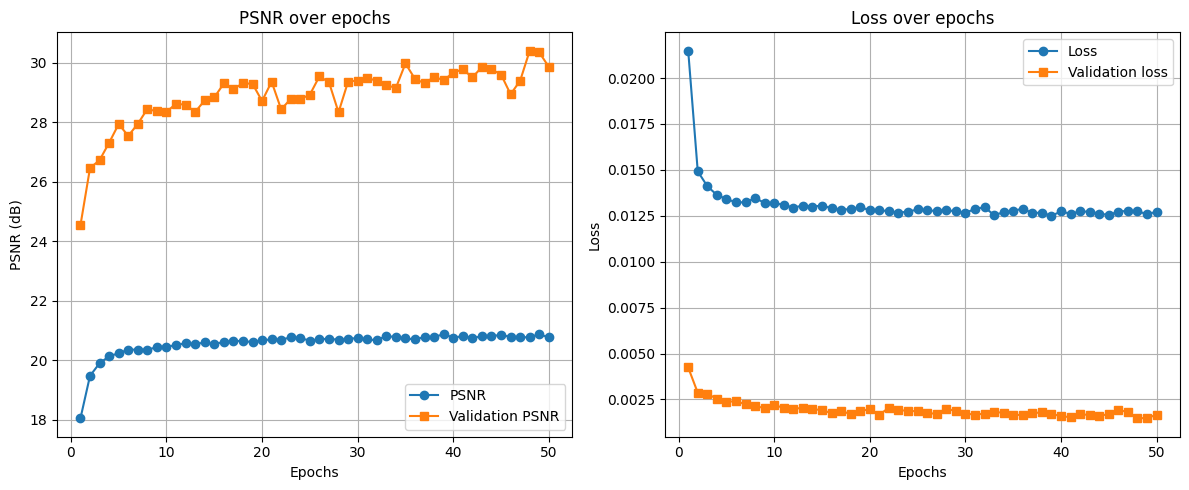

In [12]:
reload(utils)

together = utils.get_psnr_and_loss_curves(history, together=True)
# together.savefig('models/saved/n2n_imagenet10k_05122024/irfan/img/psnr_loss.pdf')
together.savefig('models/saved/n2n_imagenet10k_05122024/unet/img/psnr_loss.pdf')
together.show()


## Evaluate model

In [13]:
evals = model.evaluate(
    test_gen,
    batch_size=GPU_BATCH_SIZE,
    verbose=2
)

6/6 - 3s - loss: 0.0018 - psnr: 29.5860 - 3s/epoch - 440ms/step


In [14]:
evals

[0.0018494644900783896, 29.586042404174805]

2024-12-07 13:10:06.040942: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 353ms/step


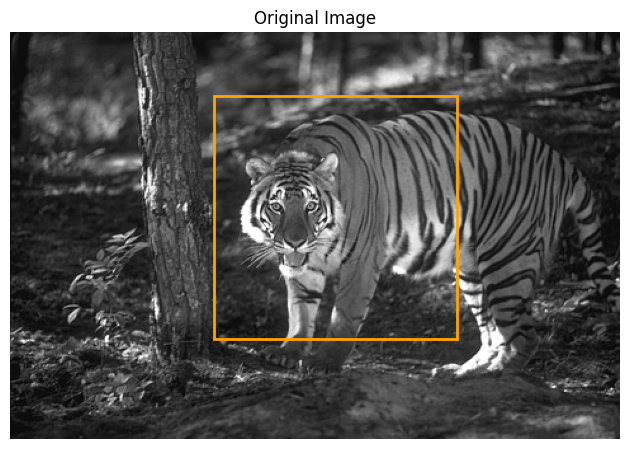

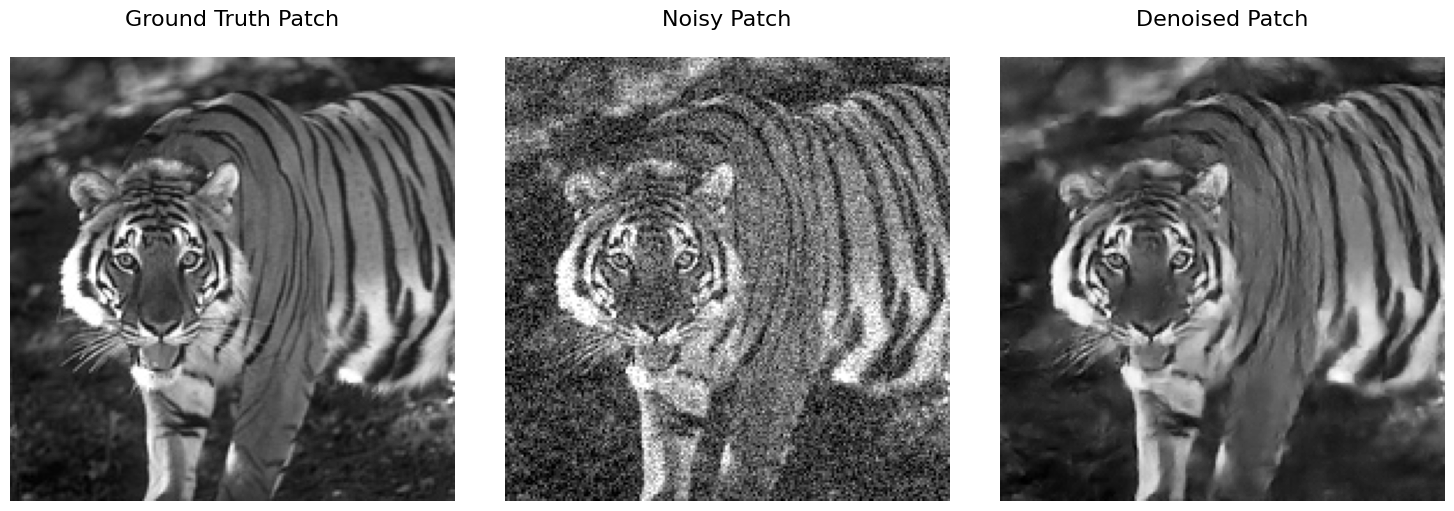

In [15]:
reload(utils)

ground_truth_fig, patches_fig = utils.test_model_on_image(
    image_path=TEST_IMAGE_DIR + "/108005.jpg", 
    model=model,
    patch_size=192, 
    zero_one_normalisation=True, 
    greyscale=True,
    stddev=30,
    patch_coords=(160, 50)
)

# ground_truth_fig.savefig('models/saved/n2n_imagenet10k_05122024/irfan/img/ground_truth_fig_1.pdf')
# patches_fig.savefig('models/saved/n2n_imagenet10k_05122024/irfan/img/patches_fig_1.pdf')

ground_truth_fig.savefig('models/saved/n2n_imagenet10k_05122024/unet/img/ground_truth_fig_1.pdf')
patches_fig.savefig('models/saved/n2n_imagenet10k_05122024/unet/img/patches_fig_1.pdf')

1/1 [==============================] - 0s 68ms/step


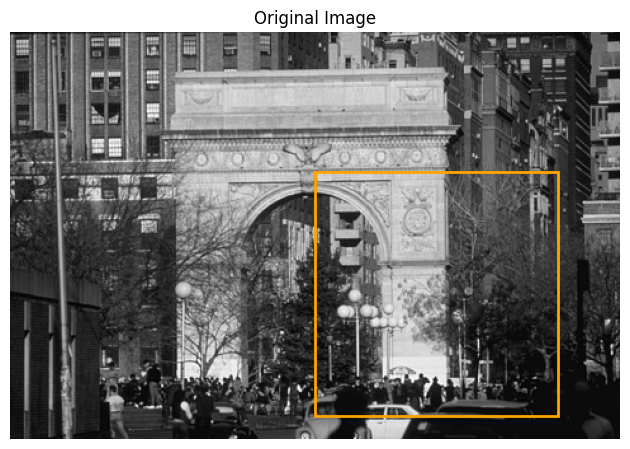

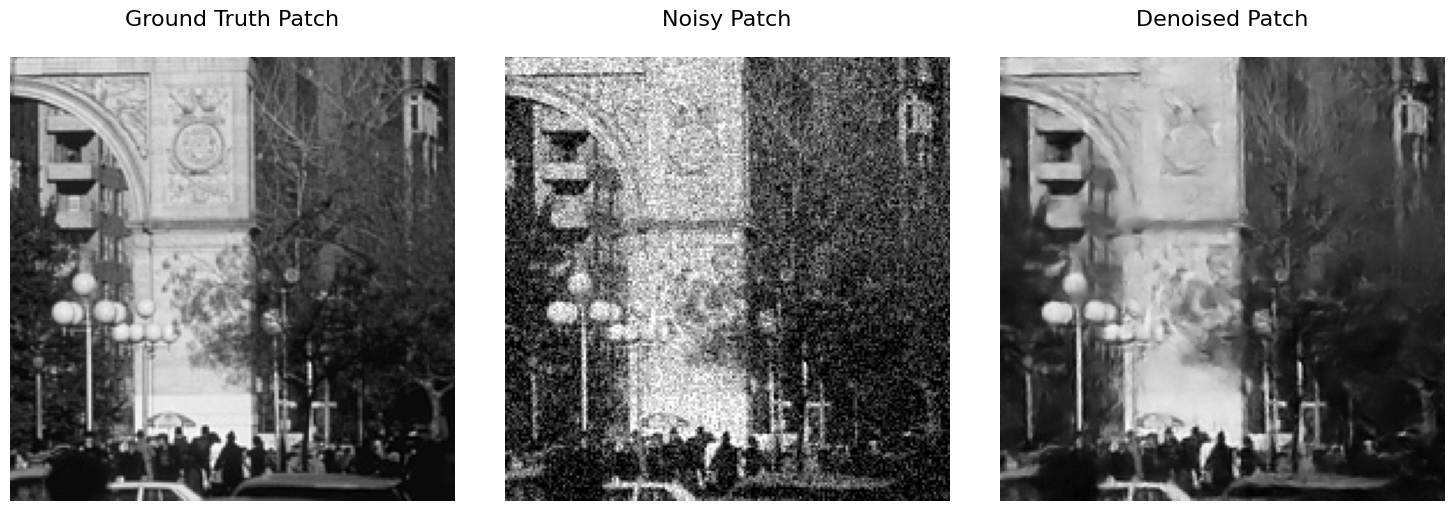

In [16]:
reload(utils)

ground_truth_fig, patches_fig = utils.test_model_on_image(
    image_path=TEST_IMAGE_DIR + "/148089.jpg", 
    model=model,
    patch_size=192, 
    zero_one_normalisation=True, 
    greyscale=True,
    stddev=30,
    patch_coords=(240, 110)
)

# ground_truth_fig.savefig('models/saved/n2n_imagenet10k_05122024/irfan/img/ground_truth_fig_2.pdf')
# patches_fig.savefig('models/saved/n2n_imagenet10k_05122024/irfan/img/patches_fig_2.pdf')

ground_truth_fig.savefig('models/saved/n2n_imagenet10k_05122024/unet/img/ground_truth_fig_2.pdf')
patches_fig.savefig('models/saved/n2n_imagenet10k_05122024/unet/img/patches_fig_2.pdf')